In [59]:
# Importing necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import my_utils as mu # comment if using kaggle

In [60]:
# Uncomment if using kaggle
#import sys
#sys.path.append('/kaggle/input/myutils')
#import my_utils as mu

In [61]:
# Setting up to code to run on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [62]:
# Transformation for the CIFAR-10 dataset
transformation = transforms.Compose(
    [transforms.RandomHorizontalFlip(),  # Randomly flipping the image
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# Loading the CIFAR-10 training dataset
trainSet = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformation)

# Loading the CIFAR-10 test dataset
testSet = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transformation)

Files already downloaded and verified
Files already downloaded and verified


In [63]:
# Defining the batch size 
batch_size = 256

# Loading the datasets
# Training dataset
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=2)

# Test dataset
testLoader = torch.utils.data.DataLoader(testSet, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=2)

In [64]:
class BackboneBlock(nn.Module):
    def __init__(self, input_channels, output_channels, k):
        super(BackboneBlock, self).__init__()
        self.k = k
        
        # Parallel 1 (Code for the vector a)
        self.block_spatial_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=input_channels, out_features=k)
        self.relu = nn.ReLU()

        # Parallel 2 (Code for convolution layers)
        conv_layers_list = []
        for i in range(k):
            # Appending the convolution layers to conv_layers_list
            conv_layers_list.append(nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1))
        
        # Adding the conv_layers_list to ModuleList
        self.conv_layers = nn.ModuleList(conv_layers_list)
        
        self.batchnorm = nn.BatchNorm2d(output_channels)  # Defining Batch Normalization
        self.maxpool = nn.MaxPool2d((2,2))  # Defining Maxpool layer with kernel size 2x2

    def forward(self, x):
        # Vector a
        a = self.block_spatial_avg_pool(x)
        a = torch.flatten(a, 1)
        a = self.fc(a)
        a = self.relu(a)
        
        # Conv layers and multiplying the output with vector a
        
        output = 0
        for i in range(self.k):
            conv_out = self.conv_layers[i]
            out_x = conv_out(x)
            ak = a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            aXconv = ak*out_x

            output += aXconv

        output = self.batchnorm(output)    # Batch Normalisation
        output = self.relu(output)    # ReLU activation
        output = self.maxpool(output)    # MaxPooling

        return output

In [85]:
class cifarNet(nn.Module):
    def __init__(self, input_channels, k, hidden_layer):
        super(cifarNet, self).__init__()
        
        # adding required blocks
        self.block_1 = BackboneBlock(3, 64, k)
        self.block_2 = BackboneBlock(64, 128, k)
        self.block_3 = BackboneBlock(128, 256, k)
        self.block_4 = BackboneBlock(256, 512, k)
        #self.block_5 = Block(512, 256, k)
        
        # Final Classifier
        self.spatial_avg_pool = nn.AdaptiveAvgPool2d(1)   # Average pooling with output size 1x1
        self.fc1 = nn.Linear(512, hidden_layer)   # First layer of MLP Classifier
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)   # Dropout layer
        self.fc2 = nn.Linear(hidden_layer, 10)   # Final layer of MLP Classifier

    def forward(self, x):
        out = x
       
        out = self.block_1(out)
        out = self.block_2(out)
        out = self.block_3(out)
        out = self.block_4(out)
        #out = self.block_5(out)

        out = self.spatial_avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [86]:
# Defining The model
model = cifarNet(input_channels=3, k=16, hidden_layer=20)

In [89]:
def train_model(model, train_data, test_data, num_epochs, lr,
              device=mu.try_gpu()):
    
    # Function to initialize the weights for Linear and Conv2d layers 
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
            
    # Applying init_weights to the model
    model.apply(init_weights)
    print('training on: ', device)
    
    # Transfering the model to the device(CPU or GPU)
    model.to(device)
    
    # Defining the optimzer and loss criteria
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    # Animator used to plot the graph
    animator = mu.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.Timer()
    
    # For loop to go through epochs
    for epoch in range(num_epochs):
        metric = mu.Accumulator(3)  # train_loss, train_acc, num_examples
        
        for i, (input_image, label) in enumerate(train_data):
            timer.start()
            
            model.train()
            optimizer.zero_grad()  # Zero the gradient before every iteration
            input_image, label = input_image.to(device), label.to(device)
            pred_label = model(input_image)
            l = loss(pred_label, label)

            # L2 Regularization ____start____
            reg_lambda = 0.001
            for param in model.parameters():
                l += reg_lambda*torch.norm(param, p=2)
            # L2 Regualrization ____stop____
            
            # Backward propagation
            l.backward()
            optimizer.step()
            
            with torch.no_grad():
                metric.add(l*input_image.shape[0], mu.accuracy(pred_label, label), input_image.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            
            # Adds the output to the graph for every 50 batches
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_data),
                             (train_loss, train_acc, None))
        
        # Calculating the test accuracy and adding to the graph
        test_acc = mu.evaluate_accuracy_gpu(model, test_data)
        animator.add(epoch+1, (None, None, test_acc))
        
    # Prints the final training accuracy    
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    
    # Prints the final test accuracy
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')




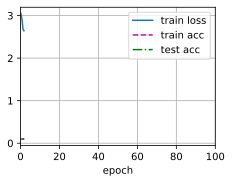

In [ ]:
n_epochs = 100    # Defining the number of epochs
lr = 0.001        # Defining the learning rate
train_model(model, trainLoader, testLoader, n_epochs, lr, device)    # Training the model